**0. Import Libraries and Read-In Data**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# when using a Jupyter notebook:
df_train = pd.read_csv('C:/Users/Bjorn/Google Drive/Development/Kaggle Competitions/data/pubg_data/train_V2.csv')
df_test = pd.read_csv('C:/Users/Bjorn/Google Drive/Development/Kaggle Competitions/data/pubg_data/test_V2.csv')
df_sample_submission = pd.read_csv('C:/Users/Bjorn/Google Drive/Development/Kaggle Competitions/data/pubg_data/sample_submission_V2.csv')

# when using Google Colab:
# df_train = pd.read_csv('/content/drive/My Drive/Development/Kaggle Competitions/data/pubg_data/train_V2.csv')
# df_test = pd.read_csv('/content/drive/My Drive/Development/Kaggle Competitions/data/pubg_data/test_V2.csv')
# df_sample_submission = pd.read_csv('/content/drive/My Drive/Development/Kaggle Competitions/data/pubg_data/sample_submission_V2.csv')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

**1. Data Exploration**

In [4]:
# Check the sample submission, observe that this is a very basic sample where every value in winPlacePerc is 1
df_sample_submission[df_sample_submission.winPlacePerc == 1]

,Id,winPlacePerc
0,9329eb41e215eb,1
1,639bd0dcd7bda8,1
2,63d5c8ef8dfe91,1
3,cf5b81422591d1,1
4,ee6a295187ba21,1
...,...,...
1934169,a316c3a13887d5,1
1934170,5312146b27d875,1
1934171,fc8818b5b32ad3,1
1934172,a0f91e35f8458f,1


In [5]:
# Check the length of df_train and df_test
print("Len of df_train is ", len(df_train))
print("Len of df_test is ", len(df_test))


Len of df_train is  4446966
Len of df_test is  1934174


In [6]:
# Explanation of the data is found here:
# https://www.kaggle.com/c/pubg-finish-placement-prediction/data
print(df_train.info())
print(df_train.describe())
print(df_train.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [7]:
# Check how many uniques are in matchType (to ensure one-hot encoding isn't complete overkill)
print("Number of unique categories in matchType: ", df_train.matchType.nunique())

print("List of match types: ", df_train.matchType.unique())


Number of unique categories in matchType:  16
List of match types:  ['squad-fpp' 'duo' 'solo-fpp' 'squad' 'duo-fpp' 'solo' 'normal-squad-fpp'
 'crashfpp' 'flaretpp' 'normal-solo-fpp' 'flarefpp' 'normal-duo-fpp'
 'normal-duo' 'normal-squad' 'crashtpp' 'normal-solo']


In [8]:
# Check if any columns have a null value
df_train.columns[df_train.isnull().any()]

Index(['winPlacePerc'], dtype='object')

In [9]:
# Check how many rows are null for winPlacePerc
df_train.winPlacePerc.isnull().sum()

1

**2. Data Visualization**

In [10]:
# save copies of original dataframes
df_original_train = df_train.copy()
df_original_test = df_test.copy()

Question: What is the relationship between number of kills and the target value (winPlacePerc)? I'll display it with a scatter plot

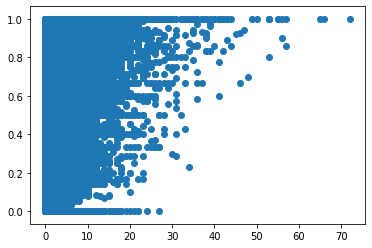

In [11]:
import matplotlib.pyplot as plt

plt.scatter(df_train.kills, df_train.winPlacePerc)
plt.show()

Just based on this visualization, there seems to be a fairly weak relationship between number of kills and winPlacePerc. See below for the full correlation matrix.

Next, I'm curious to see which match types are most common. As a player myself I obviously have a sense of this but would be curious to see how the data is distributed along that dimension.

In [12]:
match_type_counts = df_original_train.groupby(['matchType']).agg({'matchType' : ['count']})
match_type_counts.columns = ['count_type']

match_type_counts

,count_type
matchType,
crashfpp,6287
crashtpp,371
duo,313591
duo-fpp,996691
flarefpp,718
flaretpp,2505
normal-duo,199
normal-duo-fpp,5489
normal-solo,326


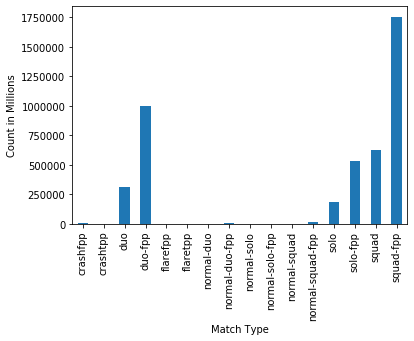

In [13]:
# Plot count of match types
match_type_counts.plot(kind='bar', rot=90, legend=None)
plt.legend
plt.ylabel("Count in Millions")
plt.xlabel("Match Type")
plt.show()

In [14]:
# Destroyng a vehicle is very rare, but just how rare is it?
# Question: What percent of players have any vehicleDestroys?
len(df_original_train[df_original_train.vehicleDestroys > 0]) / len(df_original_train)

0.007590343618548017

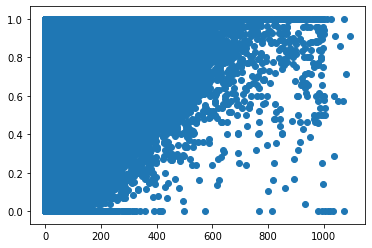

In [15]:
# Relationship between place and longestKill

plt.scatter(df_original_train.longestKill, df_original_train.winPlacePerc)

In [16]:
# Max longest kill?
df_original_train.longestKill.max()

1094.0

In [17]:
# 1000 seems insane... of players who had a longest kill, what percent are above 500?
len(df_original_train[df_original_train.longestKill > 500]) / len(df_original_train)


0.00040162213967905307

In [18]:
# That makes sense... the odds of having a longestKill > 500 yards is 0.04% (4 in ten-thousand)

# What about 200 yards?

len(df_original_train[df_original_train.longestKill > 200]) / len(df_original_train)

# Answer: 1.8% of player-games have a longest kill of 1.8%

0.018731422727315657

In [19]:
corr_matrix = df_original_train.corr()

In [20]:
# Let's focus on correlation with winPerc
corr_matrix.iloc[:,-1]

# Insights from this: Match Duration is mostly useless (which makes perfect sense)
# Reminder that higher is better (ie 1 is first place, 0 is last place)
# Very curious that killPlace has such a negative correlation....
# ...update: it's because killPlace counts DOWN as it gets better while winPerc counts UP

# remove numGroups since maxPlace  provide same information

assists            0.299441
boosts             0.634234
damageDealt        0.440507
DBNOs              0.279970
headshotKills      0.277722
heals              0.427857
killPlace         -0.719069
killPoints         0.012908
kills              0.419916
killStreaks        0.377566
longestKill        0.410154
matchDuration     -0.005171
maxPlace           0.037377
numGroups          0.039621
rankPoints         0.013523
revives            0.240881
rideDistance       0.342915
roadKills          0.034544
swimDistance       0.149607
teamKills          0.015943
vehicleDestroys    0.073436
walkDistance       0.810888
weaponsAcquired    0.583806
winPoints          0.007061
winPlacePerc       1.000000
Name: winPlacePerc, dtype: float64

In [44]:
corr_matrix[['walkDistance','kills', 'winPlacePerc']]

,walkDistance,kills,winPlacePerc
assists,0.290306,0.319690,0.299441
boosts,0.640150,0.502024,0.634234
damageDealt,0.398199,0.888783,0.440507
DBNOs,0.284660,0.707848,0.279970
headshotKills,0.250982,0.674275,0.277722
heals,0.430266,0.311781,0.427857
killPlace,-0.590236,-0.730498,-0.719069
killPoints,0.004630,0.036192,0.012908
kills,0.374774,1.000000,0.419916
killStreaks,0.327639,0.802500,0.377566


**3. Remove Irrelevant Columns**

In [22]:
# Since it's only one row that's missing a target value, simply drop it
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')

In [24]:
# Drop irrelevant ID columns
df_train.drop(columns=['Id','groupId','matchId'], inplace=True)
df_test.drop(columns=['Id', 'groupId', 'matchId'], inplace=True)

In [25]:
# Observe that some variables will be highly correlated the game type (eg assists, revives, team_kills are meaningless for solo games)
# May need to try and figure that out later...

# one-hot encode matchType (for both train and test sets)
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)


In [26]:
# Last before running the model, generate the training and validation sets

X_train = df_train.drop(columns = 'winPlacePerc')
y_train = df_train.winPlacePerc

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size = 0.8, test_size = 0.2, random_state = 0)

In [45]:
import timeit
start_time = timeit.default_timer()

# XGBoost Parameters documentation: https://xgboost.readthedocs.io/en/latest/parameter.html

# Hyperparameters to adjust:
# Eta: default is 0.3, so I'd like to try 0.005, 0.1, 0.2, and 0.4
# Gamma: default is 0, try 0.1, 0.2
# Max Depth: default is 6, try 4 and 8

# I'm going to try all combinations of the above (meaning 16 different models)
#  which will probably take two hours to run (unless I parallelize something later)

# UPDATE: If I'm going to reduce eta then I need to increase num_round... 
# ... but I can't find where the default number for num_round is... so I have no idea what to set it to

#for eta in [0.005, 0.1, 0.2, 0.3, 0.4

# Update each list of gamma and max_depth values to test.
# Note that XGBoost default values are gamma=0 and max_depth=6
gamma_list = [-1]
max_depth_list = [-1]

for gamma in gamma_list:
    for max_depth in max_depth_list:
        
        iter_start_time = timeit.default_timer()

        # Instantiate model
        # Use the below line if making use of the for-loops for hyperparameter sweeps
        #model = XGBRegressor(random_state = 0, gamma=gamma, max_depth=max_depth)
        
        # Use this line if not interested in doing a hyperparameter sweep (takes about ten min on my machine)
        model = XGBRegressor(random_state = 0)
        
        # The ideal hyperparameter for max_depth is 16, but this takes over an hour to run on my laptop:
        #model = XGBRegressor(random_state = 0, max_depth = 16)

        # Fit model
        model.fit(X_train, y_train)

        # Get predictions
        predictions = model.predict(X_valid)

        # Calculate MSE

        mse = mean_squared_error(predictions, y_valid)
        mae = mean_absolute_error(predictions, y_valid)
        
        iter_elapsed = timeit.default_timer() - iter_start_time
        
        print("**************")
        print("gamma: ", gamma,"; max_depth: ", max_depth)
        print("Mean Squared Error of XGBoostRegressor: ", mse)
        print("Mean Absolute Error of XGBoostRegressor: ", mae)
        print("Iteration seconds elapsed: ", iter_elapsed)
        print("**************")

# check time elapsed
elapsed = timeit.default_timer() - start_time
print("Total Time elapsed: ", elapsed)

[15:05:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
**************
gamma:  -1 ; max_depth:  -1
Mean Squared Error of XGBoostRegressor:  0.006104316900868401
Mean Absolute Error of XGBoostRegressor:  0.055201577276185944
Iteration seconds elapsed:  4612.9542201
**************
Total Time elapsed:  4613.0098234


In [31]:
# Gradient Boosting Trees have a few methods for regularization:
# M: the number of iterations the model uses
# the depth of the trees
# learning rate. v < 0.1 has been found to yield dramatic imrpovements in generalization (Wiki article)
# stochastic gradient boosting. Select some subsample f of the training data at each iteration. When f=1 the algorithm is deterministic and identical to the original.
#   smaller values of f introduce more randomness in the model
# Number of leaves: limiting the number of leaves improves regularization


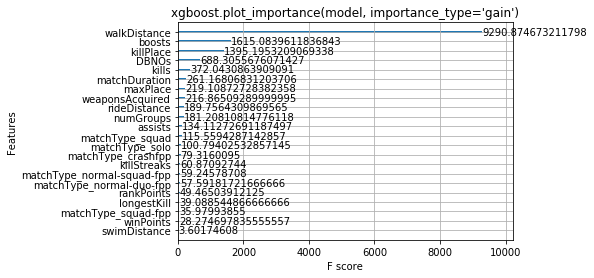

In [32]:
import matplotlib.pylab as pl
# The average training loss reduction gained when using a feature for splitting.
plot_importance(model, importance_type="gain")
pl.title("xgboost.plot_importance(model, importance_type='gain')")
pl.show()

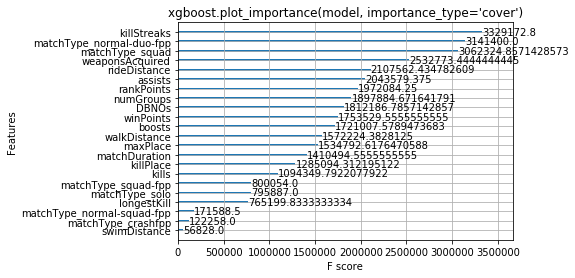

In [33]:
# The number of times a feature is used to split the data across 
# all trees weighted by the number of training data points that go through those splits.
plot_importance(model, importance_type="cover")
pl.title("xgboost.plot_importance(model, importance_type='cover')")
pl.show()

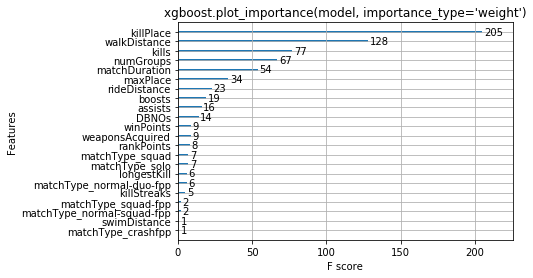

In [34]:
# The number of times a feature is used to split the data across all trees.
plot_importance(model, importance_type="weight")
pl.title("xgboost.plot_importance(model, importance_type='weight')")
pl.show()

In [35]:
import shap

In [36]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


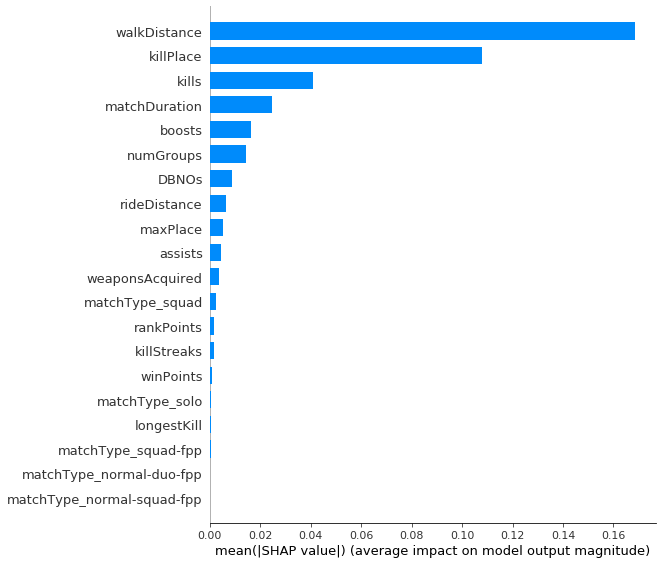

In [37]:
shap.summary_plot(shap_values, X_train, plot_type="bar")


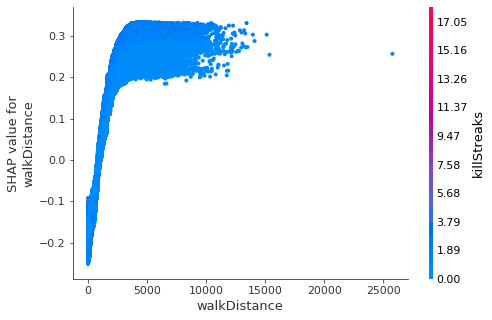

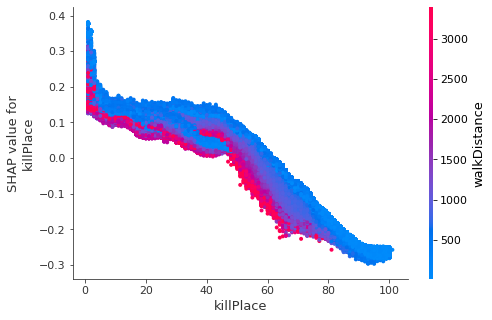

In [38]:
# Can use this for-loop to iterate over all features (columns), although 
# I found that only walkDistance and killPlace are especially interesting

for name in ['walkDistance', 'killPlace']:
    shap.dependence_plot(name, shap_values, X_train)